In [1]:
# from https://github.com/pymc-devs/pymc/wiki/Surplus

In [2]:
"""
Example from Meyer & Miller (1999) Can. J. Fish. Sci. 56:1078
Created by Aaron MacNeil on 29.07.09 
"""

""" WinBUGS model from Russel Millar's website:
(http://www.stat.auckland.ac.nz/~millar/Bayesian/Surtuna.bugs)

#State-space surplus production model for albacore tuna with lognormal errors
#############################################################################
model surplustuna {
######distribution of I's#####
for (i in 1:N) { Imean[i] <- log(Q*P[i]);
                 I[i] ~ dlnorm(Imean[i],itau2);
                 B[i] <- K*P[i] }
######distribution of P's######
Pmean[1] <- 0;
P[1] ~ dlnorm(Pmean[1],isigma2)I(0.5,2.0)
for (i in 2:N) {
    Pmean[i] <- log(max(P[i-1] + r*P[i-1]*(1-P[i-1]) - k*C[i-1],0.01));
    P[i] ~ dlnorm(Pmean[i],isigma2);
    }
#####Prior on r######
#lognormal prior corresponding to 10% and 90% of r at 0.13 and 0.48 
r~dlnorm(-1.38,3.845);
#####Prior on k######
#Lognormal prior corresponding to 10% and 90% of k at 1/300 and 1/80
k ~ dlnorm(-5.042905,3.7603664);
K <- 1/k;
MSP<-r*K/4;
#####Prior on Q#####
iq ~ dgamma(0.001,0.001);
q <- 1/iq;
Q <- q*K;
#######Priors on isigma2 and itau2#####
a0<-3.785518;  b0<-0.010223; 
c0<-1.708603; d0<-0.008613854;
isigma2 ~ dgamma(a0,b0);
itau2   ~ dgamma(c0,d0);
Sigma2<-1/isigma2; Tau2<-1/itau2;
#######Project biomass into future#####
nyrs<-10
for (i in N:(N+nyrs-1)) {C[i]<-19}
for (i in (N+1):(N+nyrs)) {
    Pmean[i] <- log(max(P[i-1] + r*P[i-1]*(1-P[i-1]) - k*C[i-1],0.01));
    P[i] ~ dlnorm(Pmean[i],isigma2);
    B[i] <- K*P[i] }

}

list(N=23, 
     C=c(15.9, 25.7, 28.5, 23.7, 25.0, 33.3, 28.2, 19.7, 17.5, 19.3, 21.6, 23.1,
         22.5, 22.5, 23.6, 29.1, 14.4, 13.2, 28.4, 34.6, 37.5, 25.9, 25.3),
     I=c(61.89, 78.98, 55.59, 44.61, 56.89, 38.27, 33.84, 36.13, 41.95, 36.63, 
         36.33, 38.82, 34.32, 37.64, 34.01, 32.16, 26.88, 36.61, 30.07, 30.75, 
         23.36, 22.36, 21.91))

list(P=c(0.99,0.98,0.96,0.94,0.92,0.90,0.88,0.86,0.84,0.82,0.80,0.78,0.76,0.74,
         0.72,0.70,0.68,0.66,0.64,0.62,0.60,0.58,0.56),r=0.8, k=0.005, iq=5, 
     isigma2=100, itau2=100)


"""


#------------------------------------------------------------------ MODULES
from pymc import invlogit, Lognormal, deterministic, stochastic, data, Uniform, MCMC, lognormal_like, Gamma, normal_like, poisson_like, potential, uniform_like, observed, Lambda, Normal, AdaptiveMetropolis
from pymc.Matplot import plot
from numpy import zeros, ones, array, mean, std, exp, sqrt, pi, log
import pdb

#------------------------------------------------------------------ DATA

catch = array([15.9, 25.7, 28.5, 23.7, 25.0, 33.3, 28.2, 19.7, 17.5, 19.3, 21.6, 23.1, 22.5, 22.5, 23.6, 29.1, 14.4, 13.2, 28.4, 34.6, 37.5, 25.9, 25.3])
cpue = array([61.89, 78.98, 55.59, 44.61, 56.89, 38.27, 33.84, 36.13, 41.95, 36.63, 36.33, 38.82, 34.32, 37.64, 34.01, 32.16, 26.88, 36.61, 30.07, 30.75, 23.36, 22.36, 21.91])
year = range(1967,1990)
P_inits = array([0.99,0.98,0.96,0.94,0.92,0.90,0.88,0.86,0.84,0.82,0.80,0.78,0.76,0.74,0.72,0.70,0.68,0.66,0.64,0.62,0.60,0.58,0.56])
nyears = len(year)

#------------------------------------------------------------------ PRIORS

# Prior distribution of K
k = Lognormal('k', -5.042905, 3.7603664, value=0.005)

# Prior distribution of r
r = Lognormal('r', -1.38, 3.845, value=0.8)

# Prior distribution for q
iq = Gamma('iq', 0.001, 0.001, value=5.)

# Hyperparameters
isigma2 = Gamma('isigma2', 3.785518, 0.010223, value=100.)
itau2 = Gamma('itau2', 1.708603, 0.008613854, value=100.)

#------------------------------------------------------------------ MODEL

# Lognormal distribution of P's
Pmean0 = 0.
P_0 = Lognormal('P_0', mu=Pmean0, tau=isigma2, trace=False, value=P_inits[0])
P = [P_0]

# Recursive step
for i in range(1,nyears):
    Pmean = Lambda("Pmean", lambda P=P[i-1], k=k, r=r: log(max(P+r*P*(1-P)-k*catch[i-1],0.01)))
    Pi = Lognormal('P_%i'%i, mu=Pmean, tau=isigma2, value=P_inits[i], trace=False)
    P.append(Pi)

# Distribution of I's
@deterministic
def Imean(q=1/iq, K=1/k, P=P):
    return array([log((q)*K*p) for p in P])

@observed
@stochastic(plot=False)
def y(value=cpue, mu=Imean, tau=itau2):
    return lognormal_like(value,mu,tau)

#-------------------- Other tidbits

# Parameters on regular scale
K=Lambda('K', lambda k=k: 1/k)
q=Lambda('q', lambda iq=iq: 1/iq)

# Variances on regular scale
Sigma2=Lambda('Sigma2', lambda isigma2=isigma2: 1/isigma2)
Tau2=Lambda('Tau2', lambda itau2=itau2: 1/itau2)

# Quantities of interest
MSP=Lambda('MSP', lambda r=r, K=K: r*K/4)
EMSP=Lambda('EMSP', lambda r=r, q=q: r/(2*q))
@deterministic
def P1990(P=P[nyears-1], r=r, C=catch[nyears-1], k=k):
    return P+r*P*(1-P)-k*C
B1990=Lambda('B1990', lambda P1990=P1990, K=K: P1990*K)

In [18]:
model = MCMC((P_0, Imean, y, MSP, EMSP, B1990, Imean, k, r, iq, isigma2, itau2))

In [19]:

model.sample(10000, thin=20, burn=100, burn_till_tuned=True)

 [-------------------------------------205%-------------------------------------] 30626 of 14900 complete in 47.6 sec

Plotting MSP
Plotting EMSP
Plotting r
Plotting B1990
Plotting k
Plotting iq
Plotting isigma2
Plotting itau2


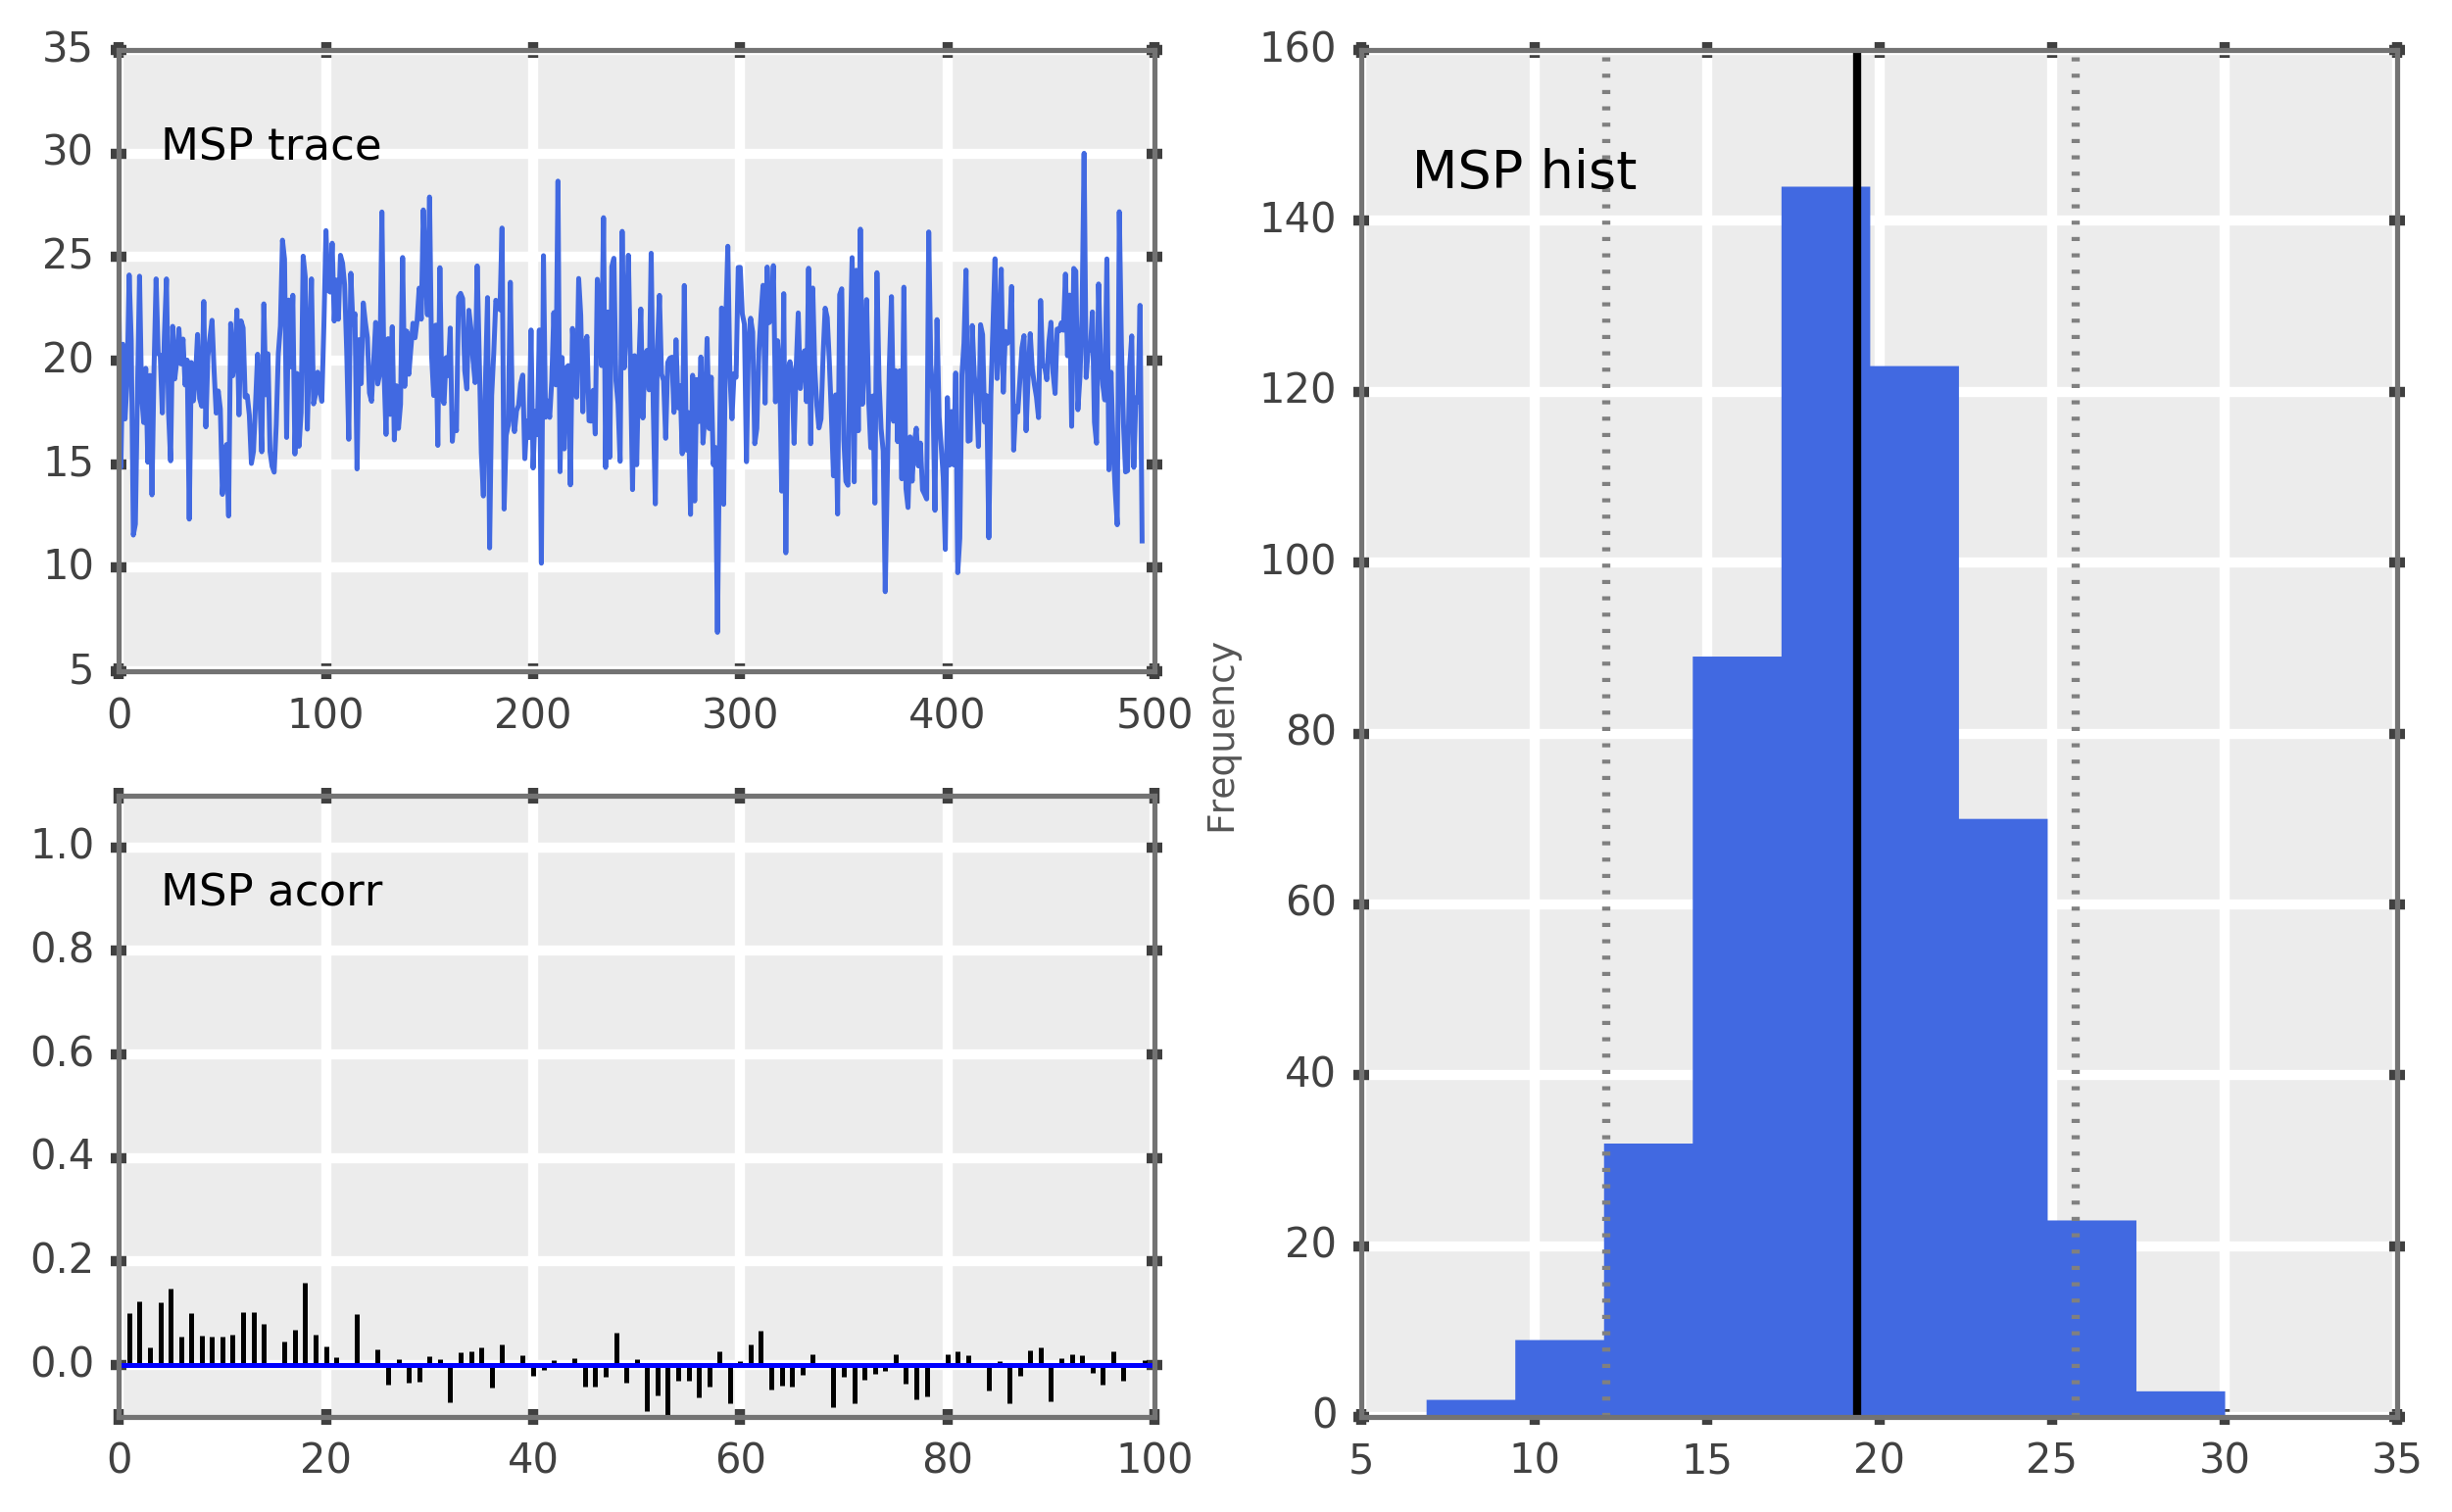

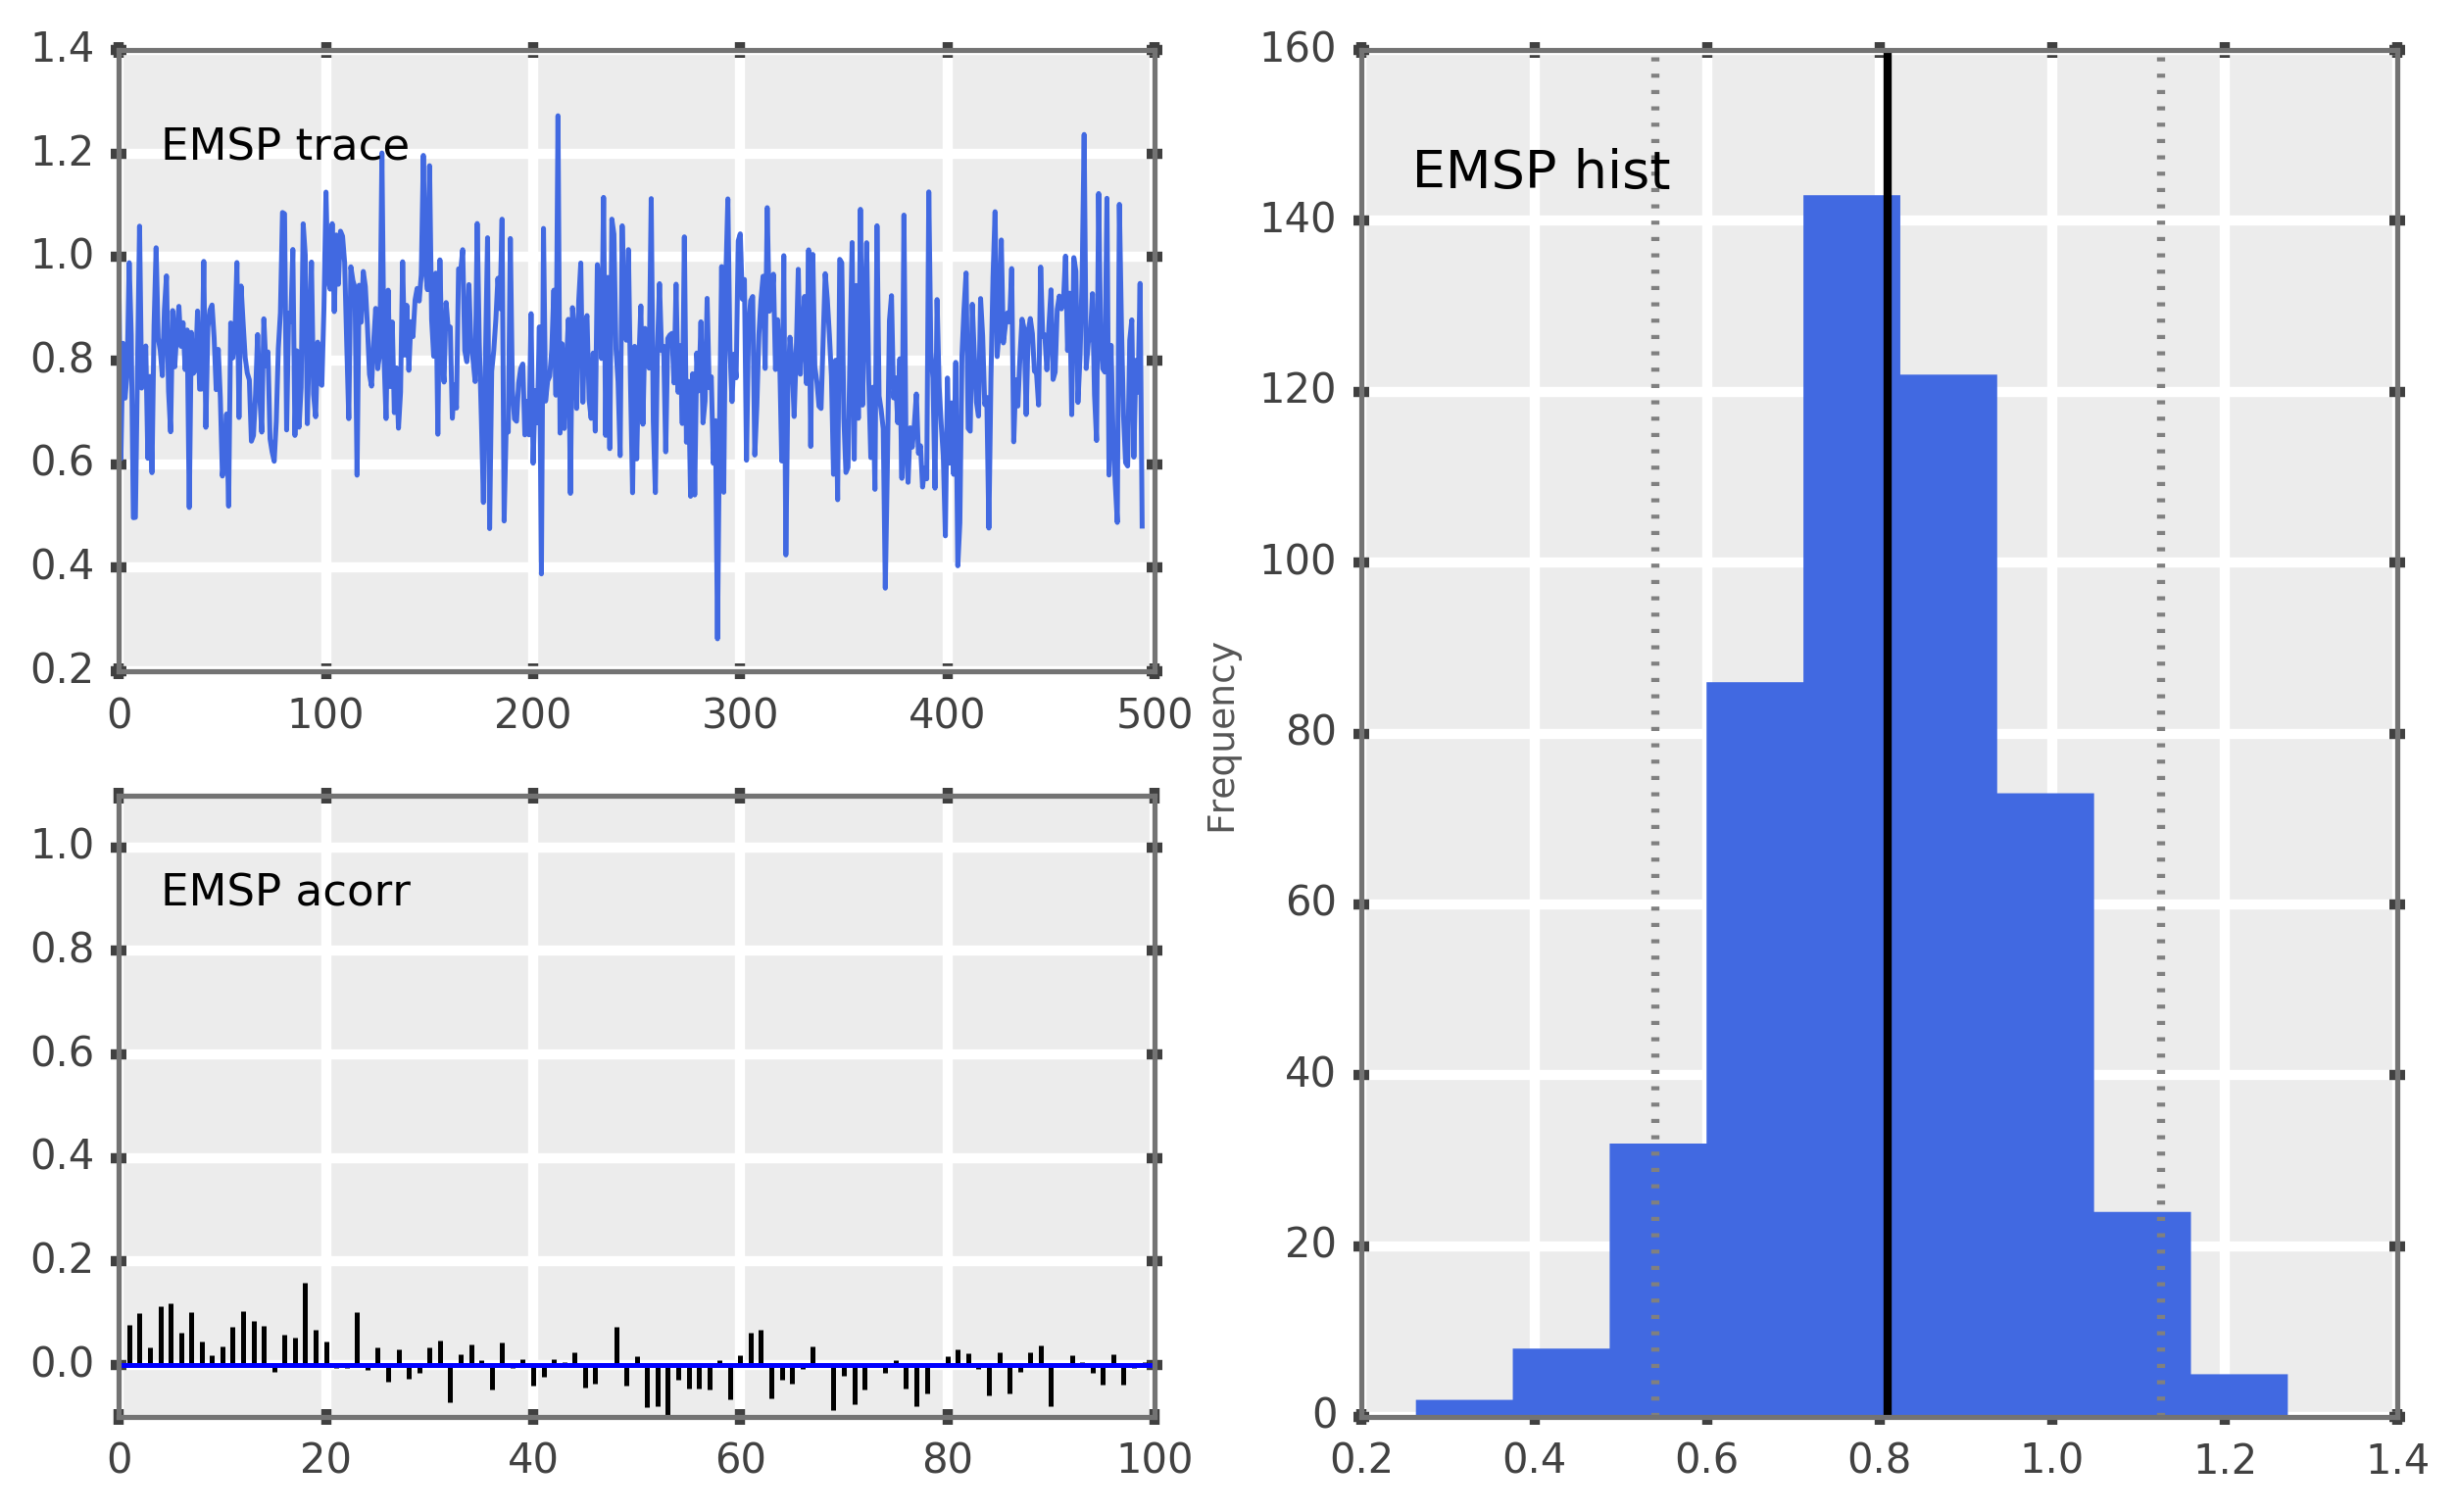

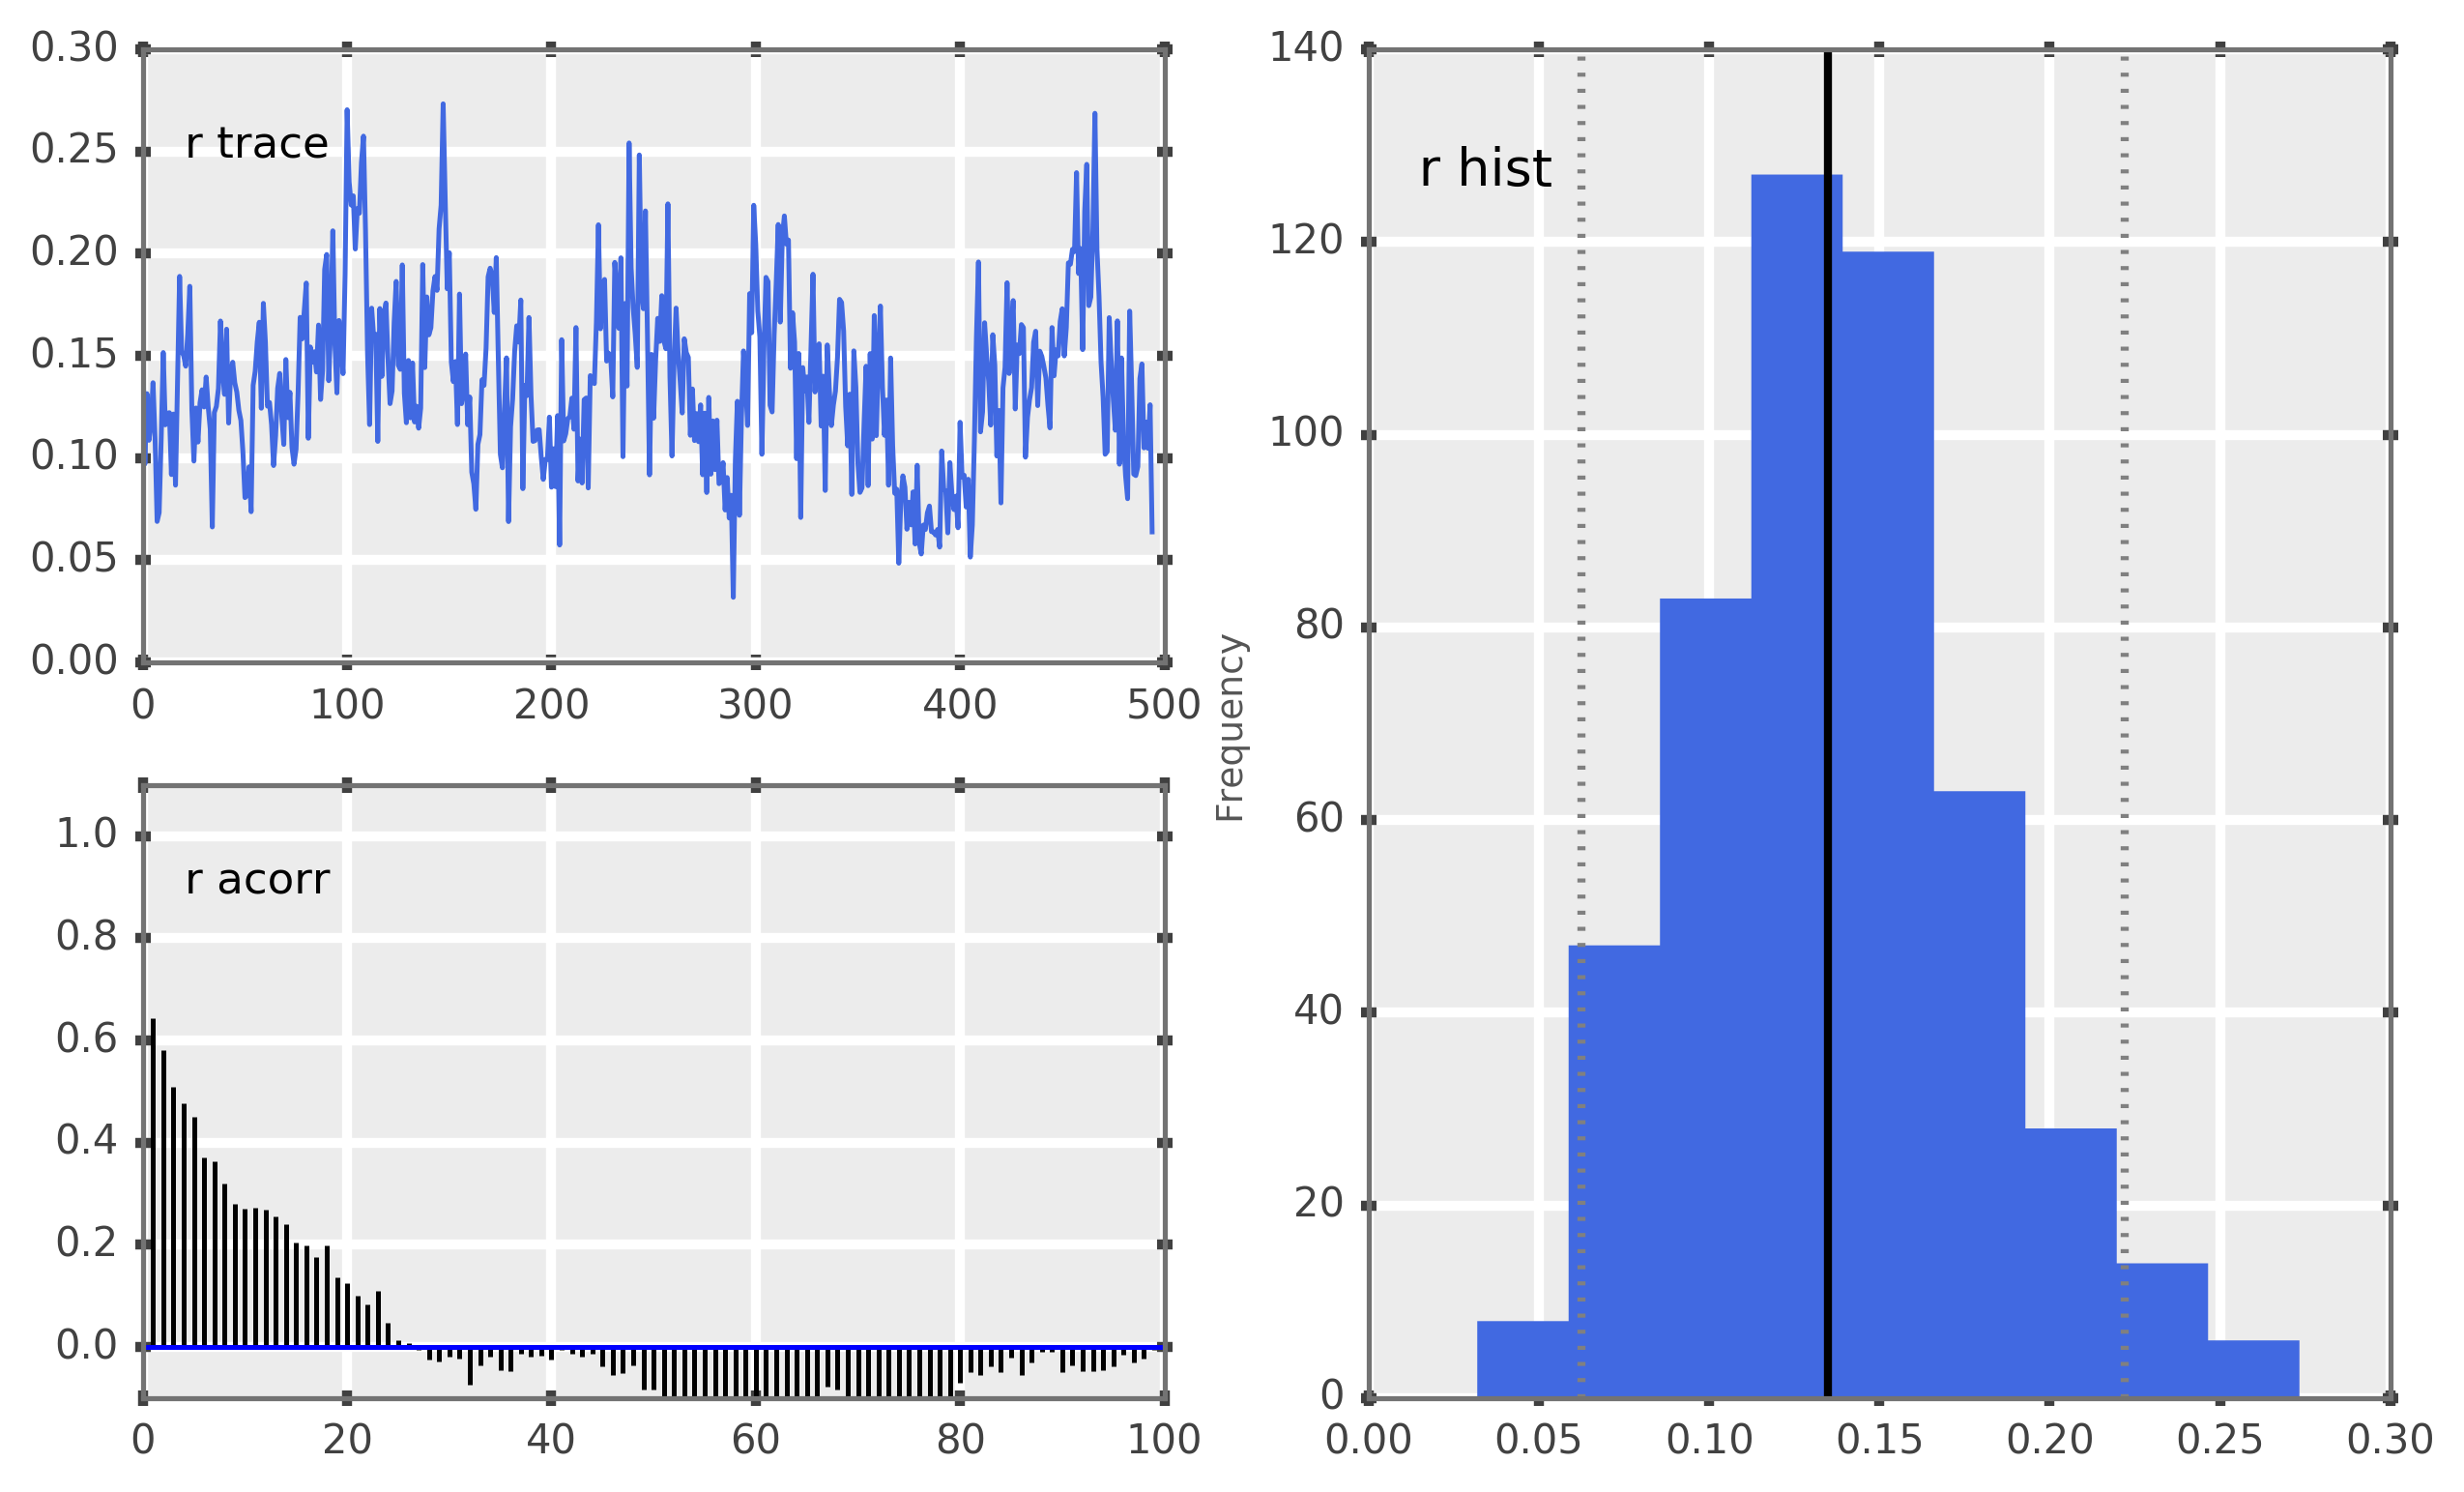

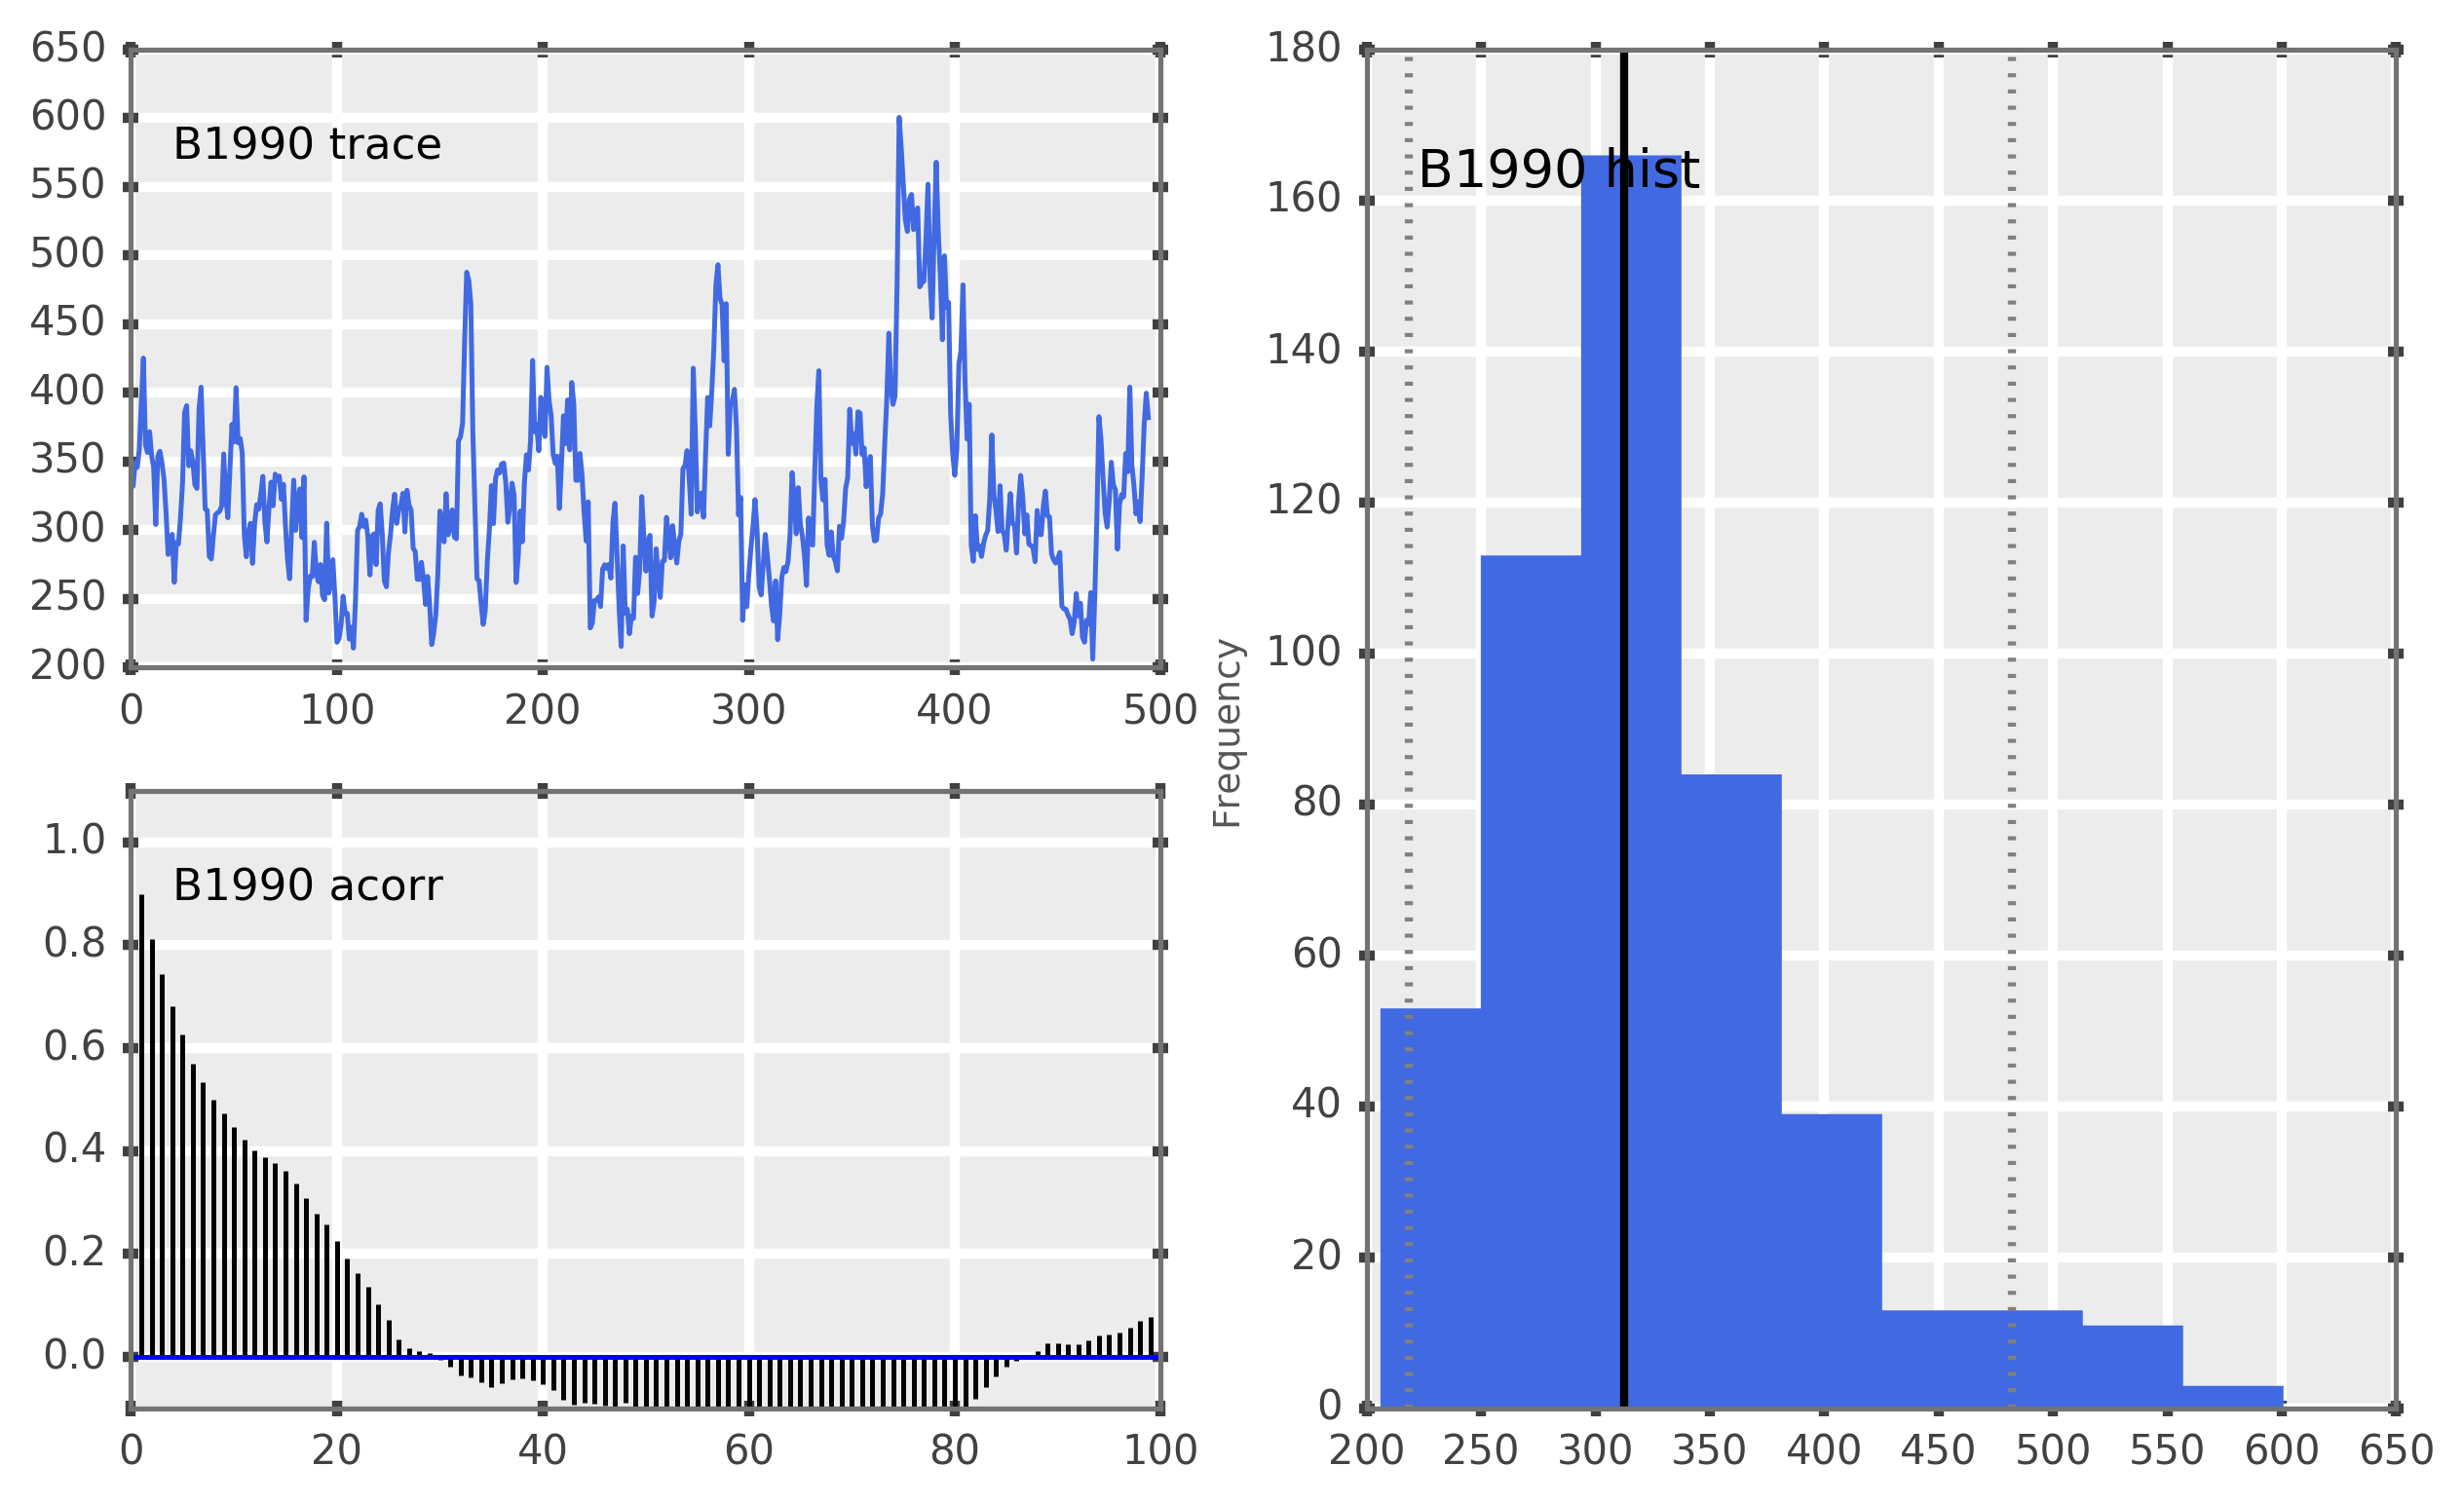

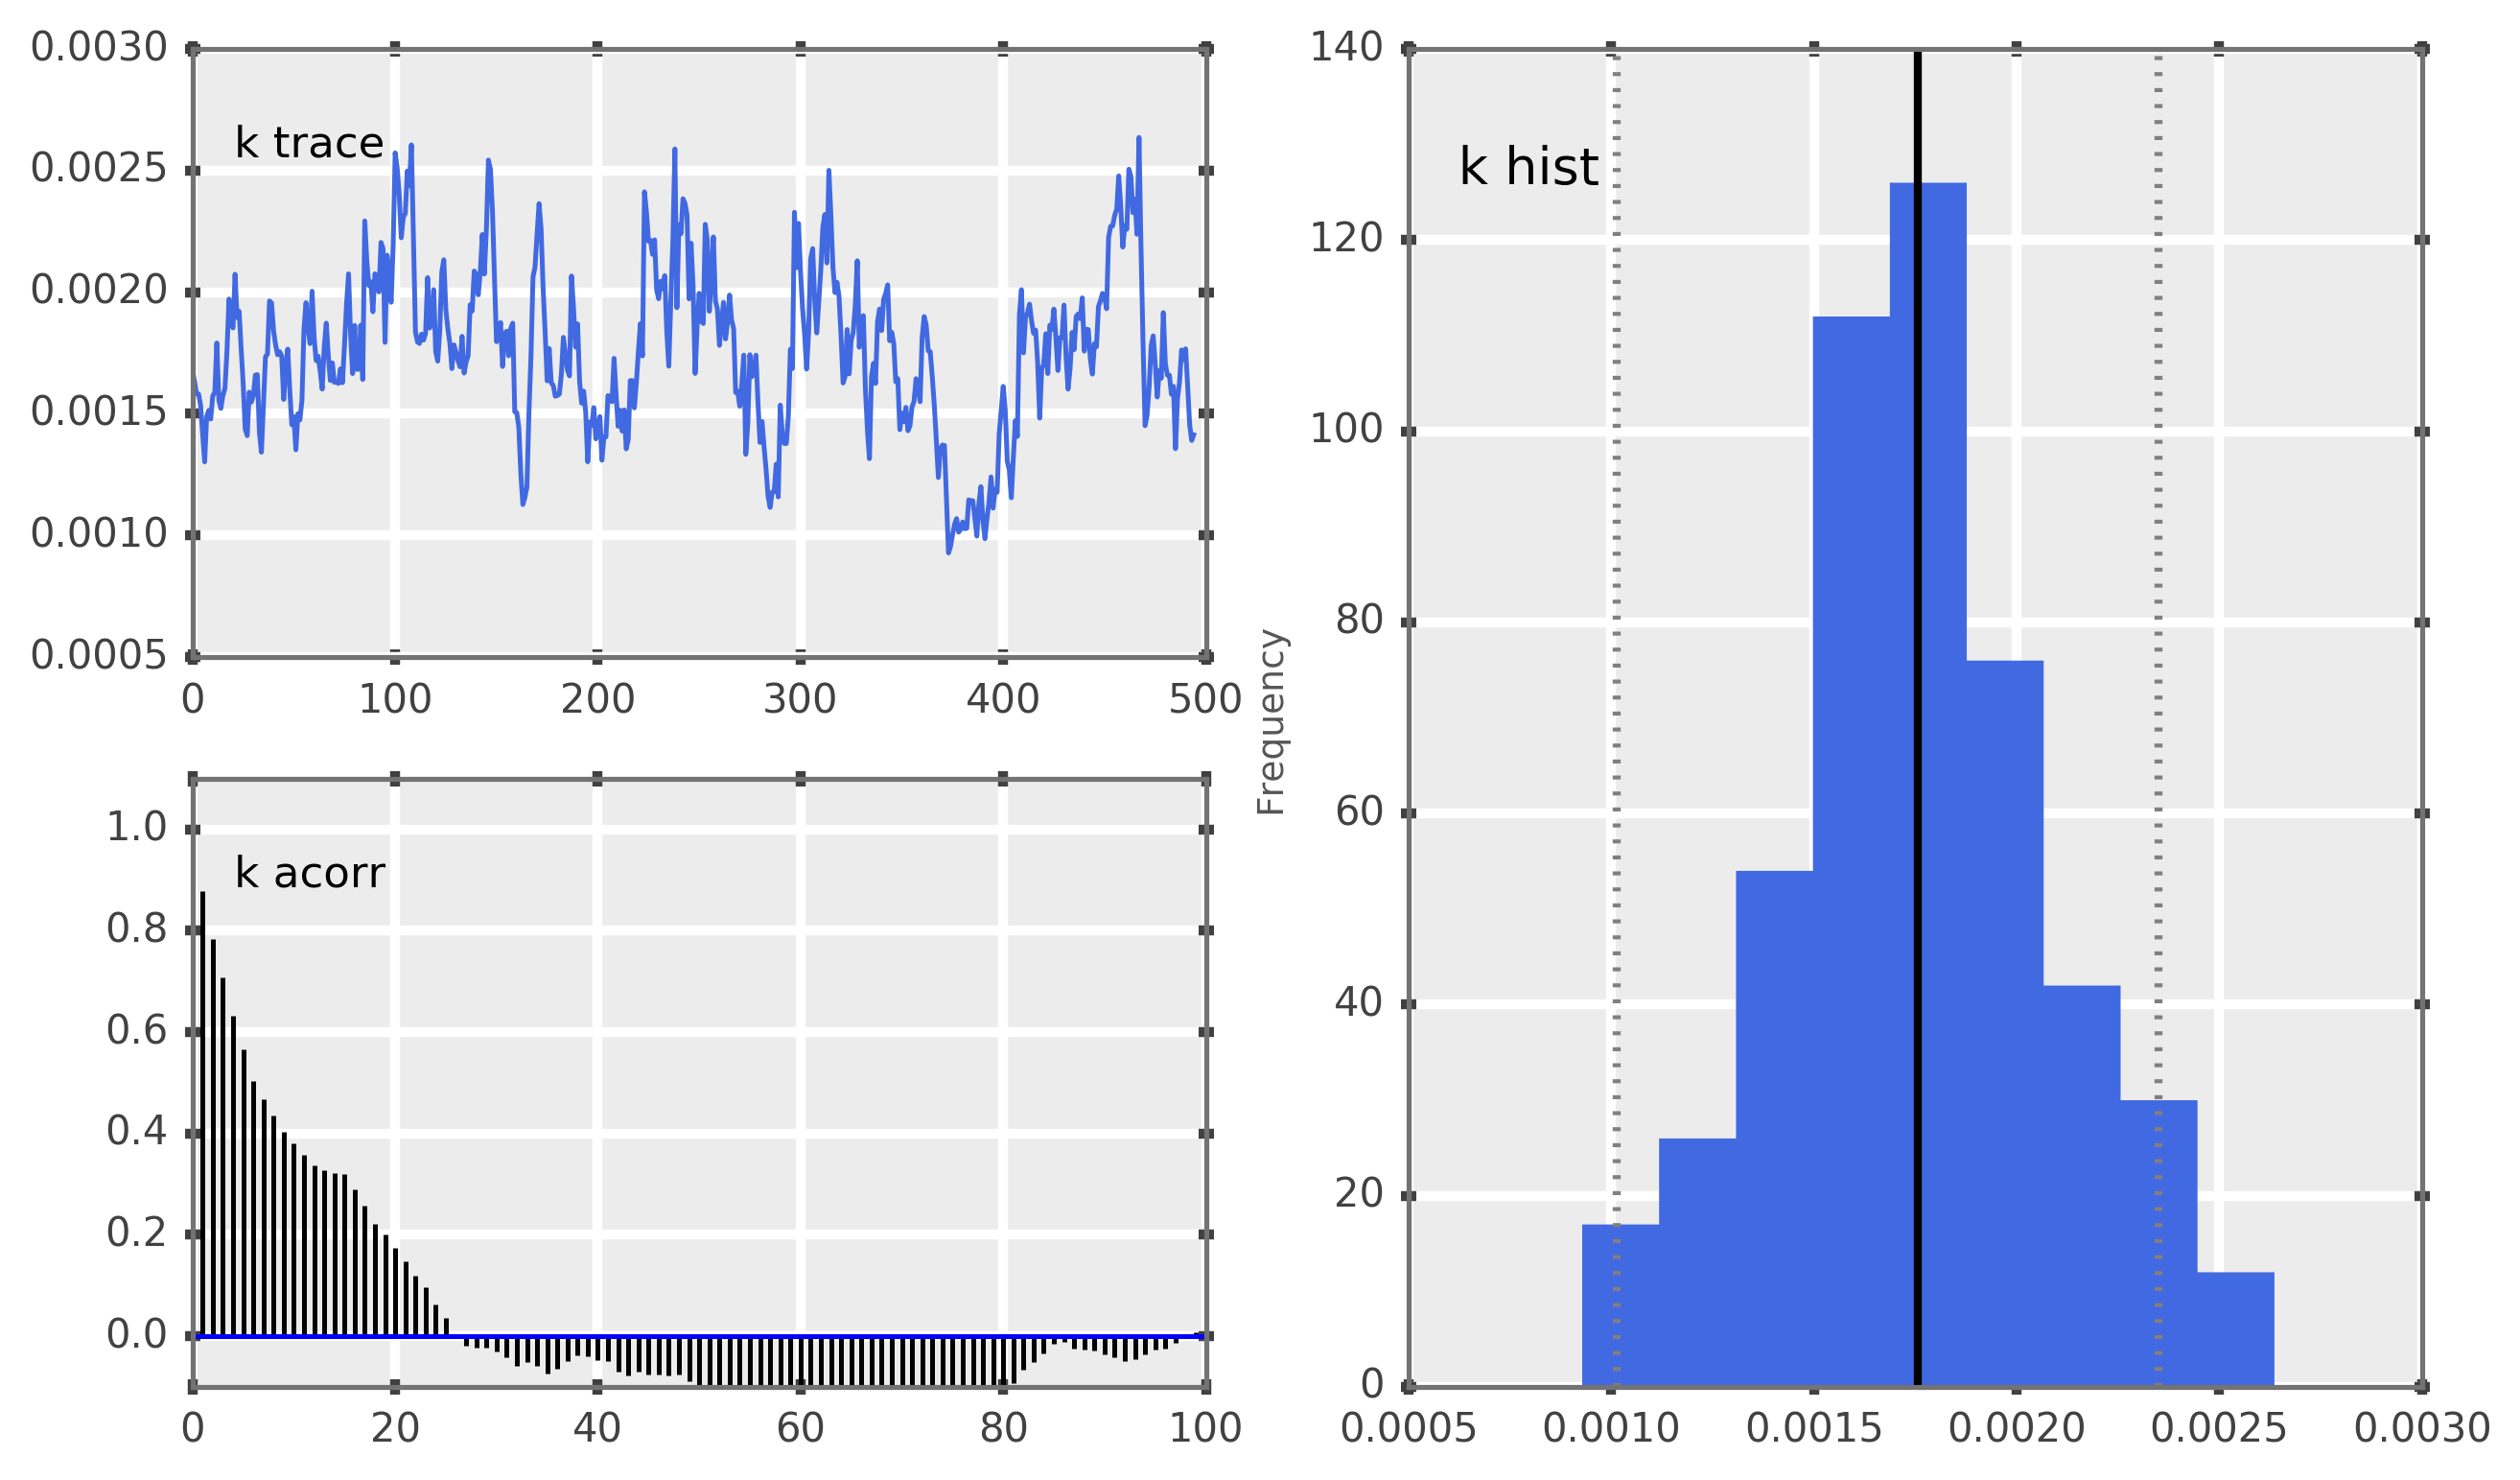

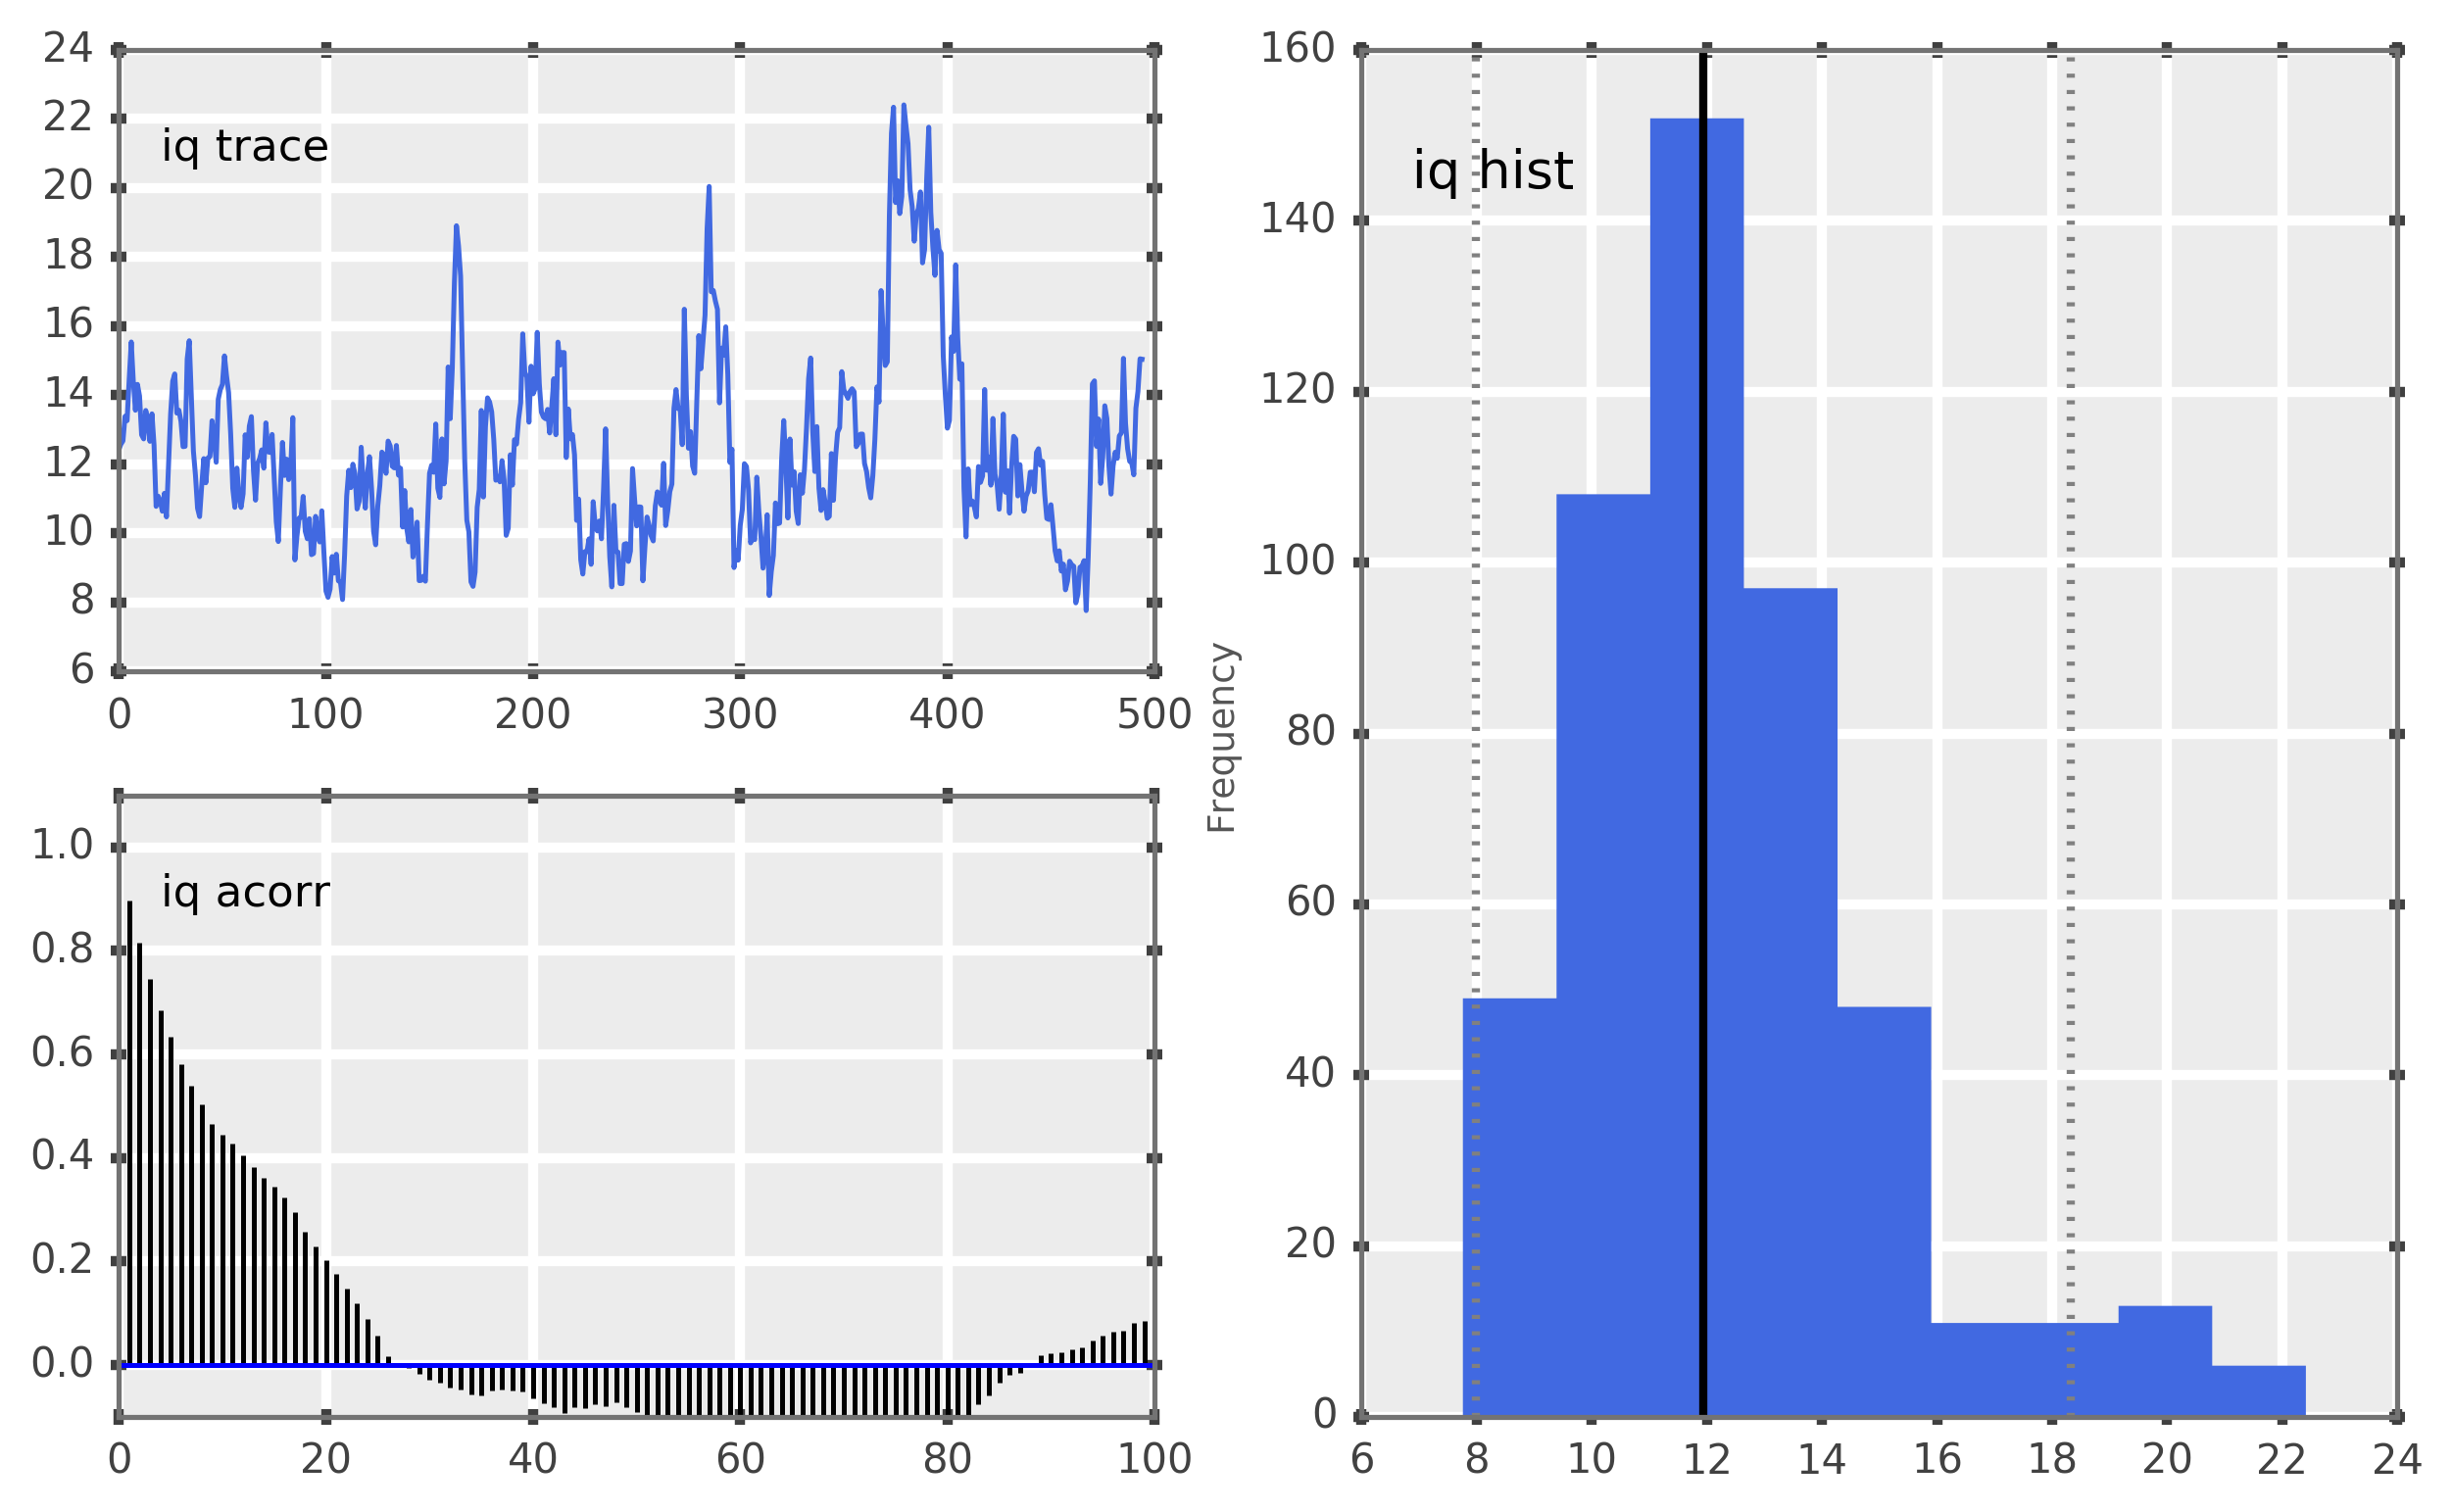

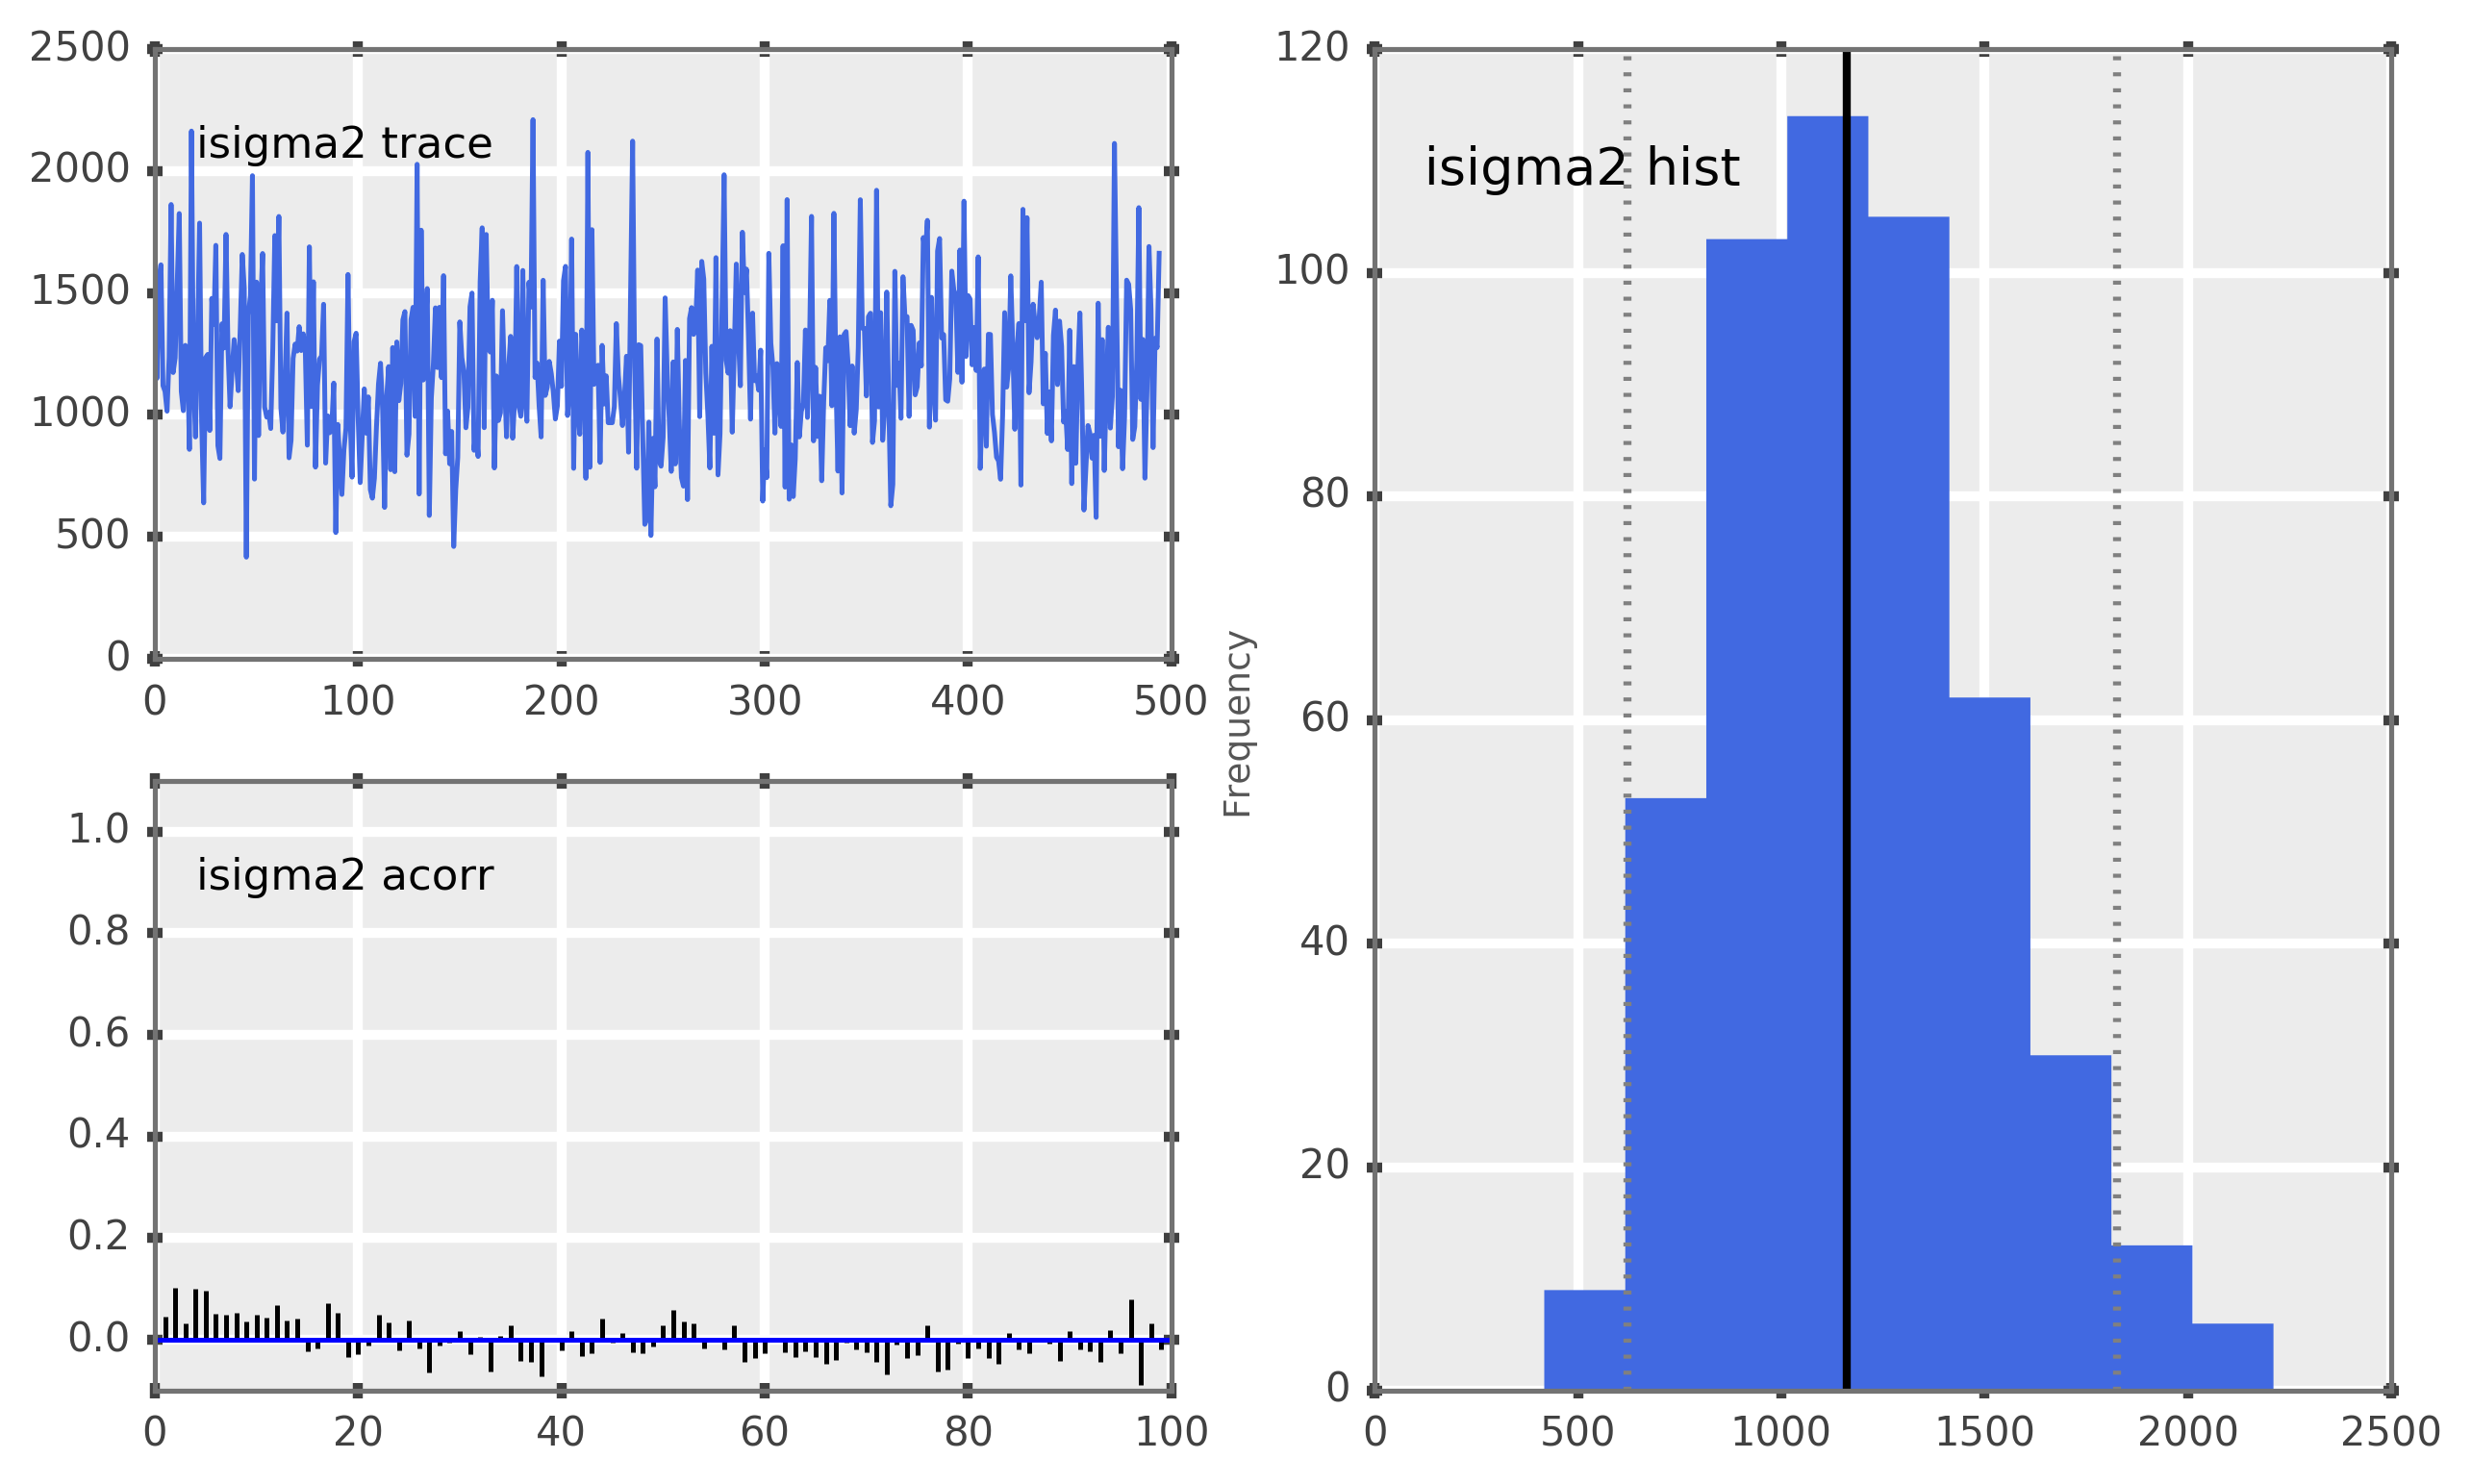

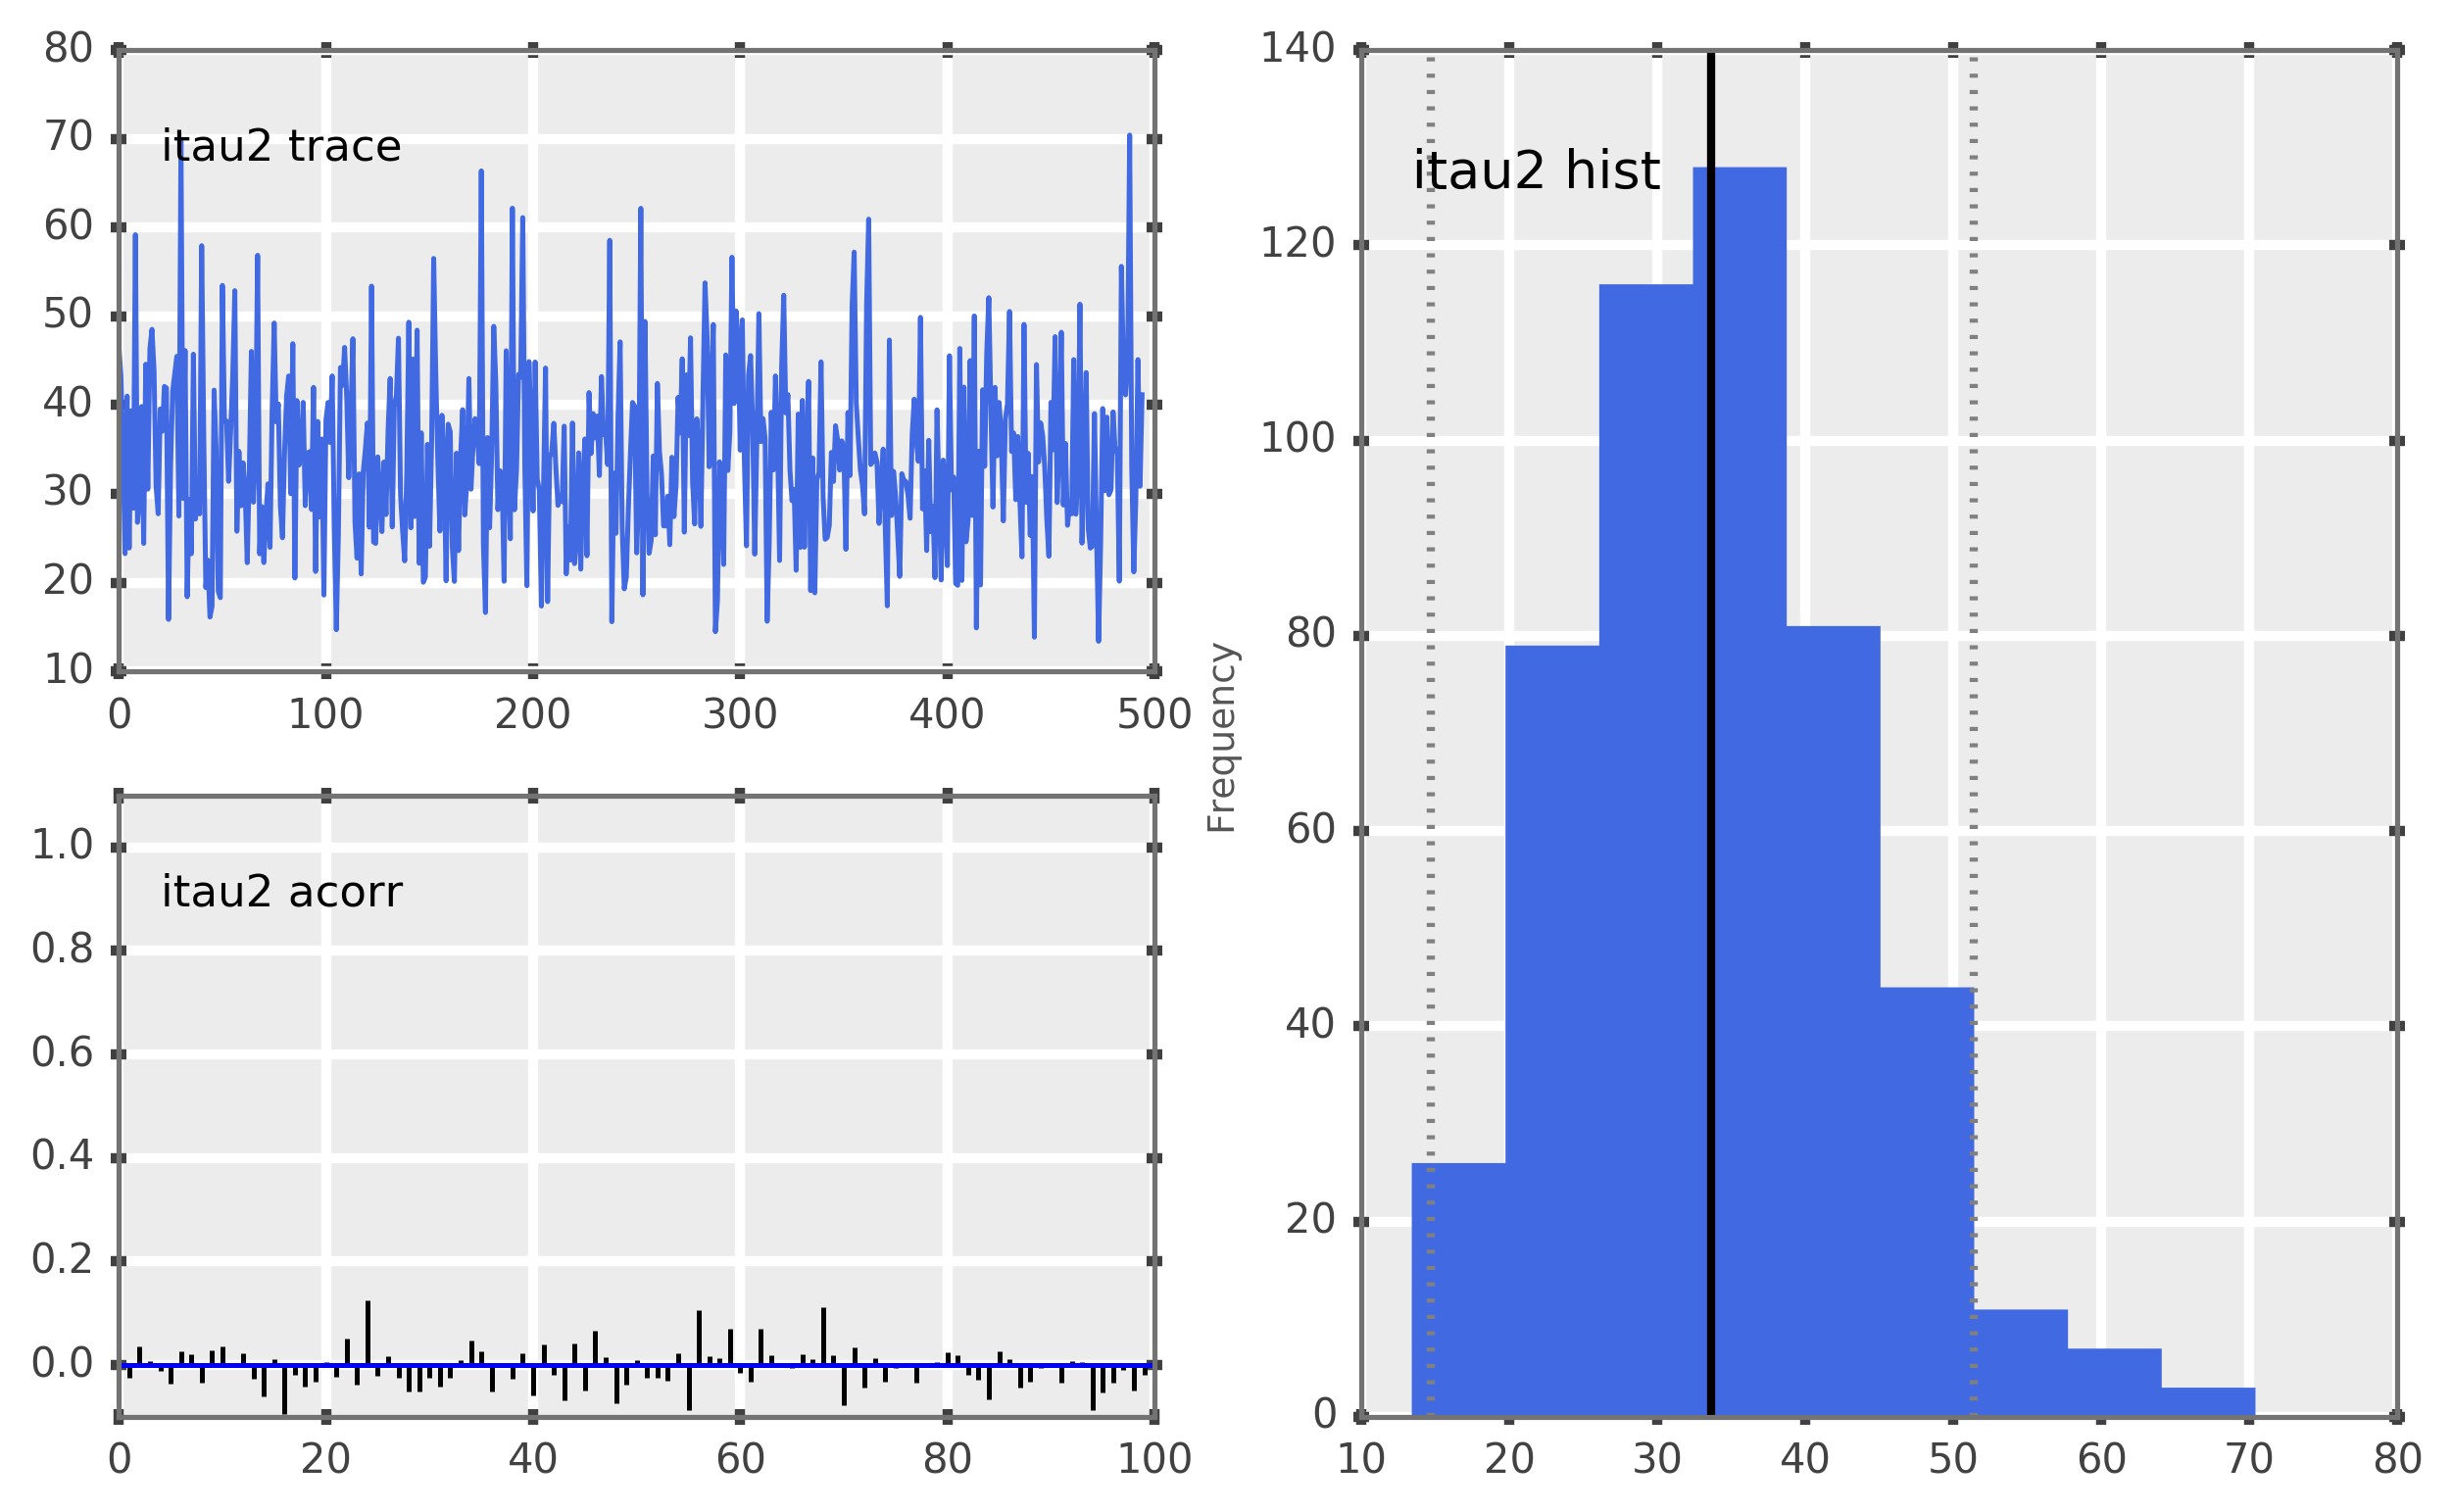

In [20]:
plot(model)

In [21]:
import spacepy.plot as spp

In [23]:
model.trace('B1990')[:]

array([ 331.78037038,  331.95860817,  349.30886594,  345.74898493,
        358.35814941,  393.48316446,  425.29959133,  362.08721853,
        356.52508144,  371.68694282,  354.08970903,  345.29519792,
        304.06513783,  353.89471066,  357.40973544,  349.10277597,
        337.22253869,  312.80110748,  282.26373797,  293.8001022 ,
        296.85822661,  261.94830769,  290.96504536,  289.75176032,
        308.6060611 ,  334.37462687,  385.67044507,  390.63691404,
        346.87773311,  357.68620579,  349.82149115,  332.98034726,
        330.39278549,  387.3366436 ,  404.11170362,  359.05190109,
        315.37710645,  314.39322213,  280.78304899,  278.96253865,
        296.25531011,  311.20266381,  312.58529194,  313.63825677,
        317.64911287,  355.49974374,  324.07337307,  308.98174071,
        343.67953114,  377.03363197,  364.21417811,  403.72718439,
        363.59847768,  366.66695607,  356.11429874,  296.61041715,
        280.57176936,  298.77714164,  304.91680267,  275.73109